In [1]:
'''
Available methods are the followings:
[1] AssoRuleMining
[2] define_dtype
[3] discretize
[4] RuleToFeature
[5] print_stats
[6] print_rule
[7] evaluate_rules
[8] create_rule
[9] GetDecisionPaths
[10] TreeRuleMining

Authors: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 31-01-2023

'''
import pandas as pd, numpy as np, time, os
from collections import namedtuple
from IPython.display import display
import ipywidgets as widgets
import multiprocessing, numbers
from joblib import Parallel, delayed
from functools import partial
from prettytable import PrettyTable
import warnings
from scipy.sparse import csc_matrix as csc, isspmatrix_csc
import sklearn
from sklearn.metrics import (confusion_matrix, f1_score)
from sklearn.ensemble import (RandomForestClassifier, 
                              ExtraTreesClassifier, 
                              RandomForestRegressor, 
                              ExtraTreesRegressor)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier, 
                          _tree)
from sklearn.utils import (check_random_state,
                           check_array)
from sklearn.utils.validation import check_is_fitted
from distutils.version import LooseVersion

__all__  = ["AssoRuleMining", 
            "define_dtype",
            "discretize",
            "RuleToFeature",
            "print_stats",
            "print_rule", 
            "evaluate_rules",
            "create_rule",
            "GetDecisionPaths",
            "rule_alert",
            "TreeRuleMining"]

In [2]:
if LooseVersion(sklearn.__version__) < LooseVersion("0.17"):
    raise Exception("TreeExplainer requires scikit-learn 0.17 or later")

D:\Users\danusorn.s\AppData\Local\Temp\ipykernel_20252\1375801020.py:1: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.17"):


In [329]:
def isnamedtuple(x):
    t = type(x)
    b = t.__bases__
    if len(b) != 1 or b[0] != tuple: return False
    f = getattr(t, '_fields', None)
    if not isinstance(f, tuple): return False
    return all(type(n)==str for n in f)

In [330]:
def Interval(Param, Value, dtype=int, left=None, right=None, closed="both"):
    '''
    '''
    Options = {"left"    : (np.greater_equal, np.less), # a<=x<b
               "right"   : (np.greater, np.less_equal), # a<x<=b
               "both"    : (np.greater_equal, np.less_equal), # a<=x<=b
               "neither" : (np.greater, np.less)} # a<x<b
    
    f0, f1 = Options[closed]
    c0 = "[" if f0.__name__.find("eq")>-1 else "(" 
    c1 = "]" if f1.__name__.find("eq")>-1 else ")"
    v0 = "-∞" if left is None else str(dtype(left))
    v1 = "+∞" if right is None else str(dtype(right))
    if left  is None: left  = -np.inf
    if right is None: right = +np.inf
    interval = ", ".join([c0+v0,v1+c1])
    tuples = (Param, dtype.__name__, interval, Value)
    err_msg = "%s must be %s or in %s, got %s " % tuples    
    
    if isinstance(Value, dtype):
        if not (f0(Value, left) & f1(Value, right)):
            raise ValueError(err_msg)
    else: raise ValueError(err_msg)

In [331]:
def StrOptions(Options, Param, Value, dtype=str):
    '''
    '''
    if Value not in Options:
        opts = f'{Param} ({dtype.__name__}) must be either '
        for n,s in enumerate(Options):
            if n<len(Options)-1: opts += f'"{s}", '
            else: opts += f' or "{s}" , got %s'
        raise ValueError(opts % Value)

In [4]:
def find_tree_paths(tree, node_id=0):
    
    '''
    Determine all paths through the tree as list of node-ids.
    
    Parameters
    ----------
    tree : sklearn.tree._tree.Tree object
        sklearn Tree 
    
    node_id : int, default=0

    Returns 
    -------
    paths : list of paths
        
    '''
    if node_id == _tree.TREE_LEAF:
        raise ValueError("Invalid node_id %s" % _tree.TREE_LEAF)

    left_child  = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    if left_child != _tree.TREE_LEAF:
        left_paths  = find_tree_paths(tree, left_child)
        right_paths = find_tree_paths(tree, right_child)
        
        for path in left_paths: path.append(node_id)
        for path in right_paths: path.append(node_id)
        paths = left_paths + right_paths
    else: paths = [[node_id]]
        
    return paths

In [5]:
def find_decision_path(Tree, feature_names=None, tree_id=0):
    
    '''
    It retrieves all decision paths contained in sklearn base 
    estimator (DecisionTreeRegressor or DecisionTreeClassifier). 
    
    Parameters
    ----------
    Tree : estimator object
        sklearn base estimator i.e. DecisionTreeRegressor or 
        DecisionTreeClassifier.
        
    feature_names : list of str, default=None
        Names of each of the features. If None, generic names will be 
        used ("X[0]"", "X[1]"", …, "X[n]").
    
    tree_id : int, default=0
        The id number of tree. 
        
    Returns
    -------
    decision_paths : dict of collections.namedtuple
        A dict with keys as "tree{tree_id}_{leaf_node_id}", and 
        namedtuple ("Results") as values, whose fields are as follows:
    
        Field        Description
        -----        -----------
        metric**     Evaluating metric 
        operator**   Relationship between rules 
        n_targets    Number of targets 
        n_samples**  Number of samples 
        p_target     % target i.e. n_targets/n_samples[0]
        p_sample**   % sample i.e. n_samples/n_samples[0] 
        recall       Recall score
        precision    Precision score
        f1_score     F1 score
        impurity**   impurity resulted from selected measure 
        rule**       A list of splitting conditions 
        
        Note: all outputs are arranged according to node id (from root to 
              leaf node). Fields with ** are only available when sklearn 
              base estimator is DecisionTreeRegressor.
        
    '''
    # Check base estimator
    if not isinstance(Tree, (DecisionTreeClassifier,
                             DecisionTreeRegressor)): 
        raise ValueError("Wrong model type. Base learner needs to "
                         "be either DecisionTreeRegressor "
                         "DecisionTreeClassifier.")
    
    # Check whether `Tree` is fitted.
    check_is_fitted(Tree, msg="This instance is not fitted yet. "
                    "Call `fit` with appropriate arguments before "
                    "using this estimator.")
    
    # Default feature names i.e. X[n]
    if feature_names is None:
        feature_names = [f"X[{n}]" for n in 
                         range(Tree.tree_.n_features)]

    # Tree attributes
    features = Tree.tree_.feature
    node_samples = Tree.tree_.n_node_samples
    thresholds = Tree.tree_.threshold
    left_nodes = Tree.tree_.children_left
    right_nodes = Tree.tree_.children_right
    leaf_nodes = right_nodes == left_nodes
    tot_samples = node_samples[0]

    # Get all paths from tree and order node.
    paths = find_tree_paths(Tree.tree_)
    for path in paths: path.reverse()

    # Map leaves to paths.
    leaf_to_path = dict((path[-1], path) for path in paths)

    # Remove the single-dimensional inner arrays.
    # values : number of sample wrt. class in each node.
    values = Tree.tree_.value.squeeze(axis=1)

    # Reshape if squeezed into a single float
    values = np.array([values]) if len(values.shape) == 0 else values

    # Determine rule for each decision path
    rule = dict()
    for leaf,path in leaf_to_path.items():
        rule.update({leaf:[]})
        for n0,n1 in zip(path[:-1],path[1:]):
            sign = "<=" if n1 in left_nodes else ">"
            rule[leaf].append((feature_names[features[n0]], 
                               sign, thresholds[n0])) 

    # Returning results
    decision_paths = dict()
    if isinstance(Tree, DecisionTreeClassifier): 
        
        for leaf,path in leaf_to_path.items():
            n_targets = values[path,:][:,1]
            n_samples = node_samples[path]
            precision = n_targets/n_samples
            recall = n_targets/n_targets[0]
  
            values_ = {"metric"    : Tree.criterion,
                       "operator"  : "and",
                       "n_targets" : n_targets.astype(int), 
                       "n_samples" : n_samples.astype(int), 
                       "p_target"  : n_targets/tot_samples, 
                       "p_sample"  : n_samples/tot_samples, 
                       "recall"    : recall, 
                       "precision" : precision, 
                       "f1_score"  : (2 * precision * recall / 
                                      np.fmax(precision + recall, 1)), 
                       "impurity"  : Tree.tree_.impurity[path], 
                       "rule"      : rule[leaf]}
            decision_paths[f"T{tree_id}-{leaf}"] = \
            namedtuple("Results", values_.keys())(**values_)
        
    elif isinstance(Tree, DecisionTreeRegressor):
        
        for leaf,path in leaf_to_path.items():
            n_samples = node_samples[path]
       
            values_ = {"metric"    : Tree.criterion,
                       "operator"  : "and",
                       "n_samples" : n_samples.astype(int), 
                       "p_sample"  : n_samples/tot_samples,  
                       "impurity"  : Tree.tree_.impurity[path], 
                       "rule"      : rule[leaf]}
            decision_paths[f"T{tree_id}-{leaf}"] = \
            namedtuple("Results", values_.keys())(**values_)
            
    return decision_paths

In [6]:
class GetDecisionPaths:
    
    '''
    It retrieves all decision paths contained in sklearn base 
    estimator i.e. DecisionTreeClassifier or DecisionTreeRegressor.
    
    Parameters
    ----------
    min_precision : float, default=1e-4
        The minimum precision required to be at a leaf node. This is
        relevant when base estimator is DecisionTreeClassifier.
        
    min_recall : float, default=1e-4
        The minimum recall required to be at a leaf node. This is
        relevant when base estimator is DecisionTreeClassifier.
        
    min_f1_score : float, default=1e-4
        The minimum f1-score required to be at a leaf node. This is
        relevant when base estimator is DecisionTreeClassifier.
    
    Attributes
    ----------
    decision_paths : dict of collections.namedtuple
        A dict with keys as "tree{tree_id}_{leaf_node_id}", and 
        namedtuple ("Results") as values, whose fields are as follows:

        Field        Description
        -----        -----------
        metric**     Evaluating metric 
        operator**   Relationship between rules 
        n_targets    Number of targets 
        n_samples**  Number of samples 
        p_target     % target i.e. n_targets/n_samples[0]
        p_sample**   % sample i.e. n_samples/n_samples[0] 
        recall       Recall score
        precision    Precision score
        f1_score     F1 score
        impurity**   impurity resulted from selected measure 
        rule**       A list of splitting conditions 

        Note: all outputs are arranged according to node id (from root to 
              leaf node). Fields with ** are only available when sklearn 
              base estimator is DecisionTreeRegressor.

    info : dict of numpy (masked) ndarrays
        A dict with keys as column headers. It can be imported into a 
        pandas DataFrame, whose fields are as follows:

        Field       Description
        -----       -----------
        key**       "T{tree_id}-{leaf_node_id}"
        depth**     The depth of the decision path
        n_targets   Number of targets at leaf node
        n_samples** Number of samples at leaf node
        recalls     Recall scores
        precisions  Precision scores
        f1_scores   F1 scores
        impurity**  impurity resulted from selected measure

        Note: Fields with ** are only available when sklearn base 
              estimator is DecisionTreeRegressor.
                  
    '''
    classifiers = (DecisionTreeClassifier, 
                   RandomForestClassifier, 
                   ExtraTreesClassifier)
    regressors  = (DecisionTreeRegressor , 
                   RandomForestRegressor ,
                   ExtraTreesRegressor)
        
    def __init__(self, min_precision=1e-4, min_recall=1e-4, 
                 min_f1_score=1e-4):
        
        self.__PositiveFloat__("min_precision", min_precision)
        self.__PositiveFloat__("min_recall", min_recall)
        self.__PositiveFloat__("min_f1_score", min_f1_score)
        self.min_precision = min_precision
        self.min_recall = min_recall
        self.min_f1_score = min_f1_score
        
    def __PositiveFloat__(self, name, value):
        
        err_msg = "%s must be positive float or in "\
        "(0., 1.], got %s" % (name, value)
        if isinstance(value, float):
            if not 0. < value <= 1.: 
                raise ValueError(err_msg)
        else: raise ValueError(err_msg)
    
    def fit(self, estimator, feature_names=None):
        
        '''
        Fit model.

        Parameters
        ----------
        estimator : fitted estimator object
            The object must be the following scikit-learn estimator:
            - DecisionTreeClassifier
            - ExtraTreeClassifier
            - RandomForestClassifier
            - DecisionTreeRegressor 
            - RandomForestRegressor
            - ExtraTreesRegressor
        
        feature_names : list of str, default=None
            Names of each of the features. If None, generic names will be 
            used ("X[0]"", "X[1]"", …, "X[n]").
 
        Attributes
        ----------
        decision_paths : dict of collections.namedtuple
            A dict with keys as "tree{tree_id}_{leaf_node_id}", and 
            namedtuple ("Results") as values, whose fields are as follows:

            Field        Description
            -----        -----------
            metric**     Evaluating metric 
            operator**   Relationship between rules 
            n_targets    Number of targets 
            n_samples**  Number of samples 
            p_target     % target i.e. n_targets/n_samples[0]
            p_sample**   % sample i.e. n_samples/n_samples[0] 
            recall       Recall score
            precision    Precision score
            f1_score     F1 score
            impurity**   impurity resulted from selected measure 
            rule**       A list of splitting conditions 

            Note: all outputs are arranged according to node id (from root to 
                  leaf node). Fields with ** are only available when sklearn 
                  base estimator is DecisionTreeRegressor.
        
        info : dict of numpy (masked) ndarrays
            A dict with keys as column headers. It can be imported into a 
            pandas DataFrame, whose fields are as follows:

            Field       Description
            -----       -----------
            key**       "T{tree_id}-{leaf_node_id}"
            depth**     The depth of the decision path
            n_targets   Number of targets at leaf node
            n_samples** Number of samples at leaf node
            recalls     Recall scores
            precisions  Precision scores
            f1_scores   F1 scores
            impurity**  impurity resulted from selected measure
            
            Note: Fields with ** are only available when sklearn base 
                  estimator is DecisionTreeRegressor.
            
        '''
        # Only single response variable supported (binary)
        if estimator.n_outputs_ > 1:
            raise ValueError("Multilabel classification trees not supported")
        
        if isinstance(estimator, self.classifiers): 
            self.estimator = estimator
            self.is_classifer = True
        elif isinstance(estimator, self.regressors): 
            self.estimator = estimator
            self.is_classifer = False
        else: raise ValueError("Wrong model type. Estimator needs to "
                               "be sklearn mdoel whose base learner is"
                               "either DecisionTreeRegressor or" 
                               "DecisionTreeClassifier.")
        
        if isinstance(self.estimator, (DecisionTreeClassifier,
                                       DecisionTreeRegressor)):
            self.decision_paths = find_decision_path(self.estimator, 
                                                     feature_names, 0)
        else:    
            self.decision_paths = dict()
            for n,Tree in enumerate(self.estimator):
                args = (Tree, feature_names, n)
                decision_paths = find_decision_path(*args)
                self.decision_paths.update(find_decision_path(*args))     
    
        self.__FilterPath__()
        self.__CreateInfo__()
        try: self.n_paths = len(self.info["key"])
        except: self.n_paths = 0
        
        return self
    
    def __FilterPath__(self):
        
        if self.is_classifer: 
            remove_keys = []
            for key in self.decision_paths:
                rule  = self.decision_paths[key]
                cond  = self.min_precision <= rule.precision[-1]    
                cond &= self.min_recall <= rule.recall[-1]
                cond &= self.min_f1_score <= rule.f1_score[-1]
                if not cond: remove_keys.append(key)
            
            if len(remove_keys)>0:
                for key in remove_keys:
                    _ = self.decision_paths.pop(key)
    
    def __CreateInfo__(self):
        
        '''
        Summary of all decision paths.
        
        Attributes
        ----------
        info : dict of numpy (masked) ndarrays
            A dict with keys as column headers. It can be imported into a 
            pandas DataFrame, whose fields are as follows:

            Field       Description
            -----       -----------
            key**       "T{tree_id}-{leaf_node_id}"
            depth**     The depth of the decision path
            n_targets   Number of targets at leaf node
            n_samples** Number of samples at leaf node
            recalls     Recall scores
            precisions  Precision scores
            f1_scores   F1 scores
            impurity**  impurity resulted from selected measure
            
            Note: Fields with ** are only available when sklearn base 
                  estimator is DecisionTreeRegressor.
                  
        '''
        data = []
        if self.is_classifer:
            for var,a in self.decision_paths.items():
                data += [{"key"        : var, 
                          "depth"      : len(a.rule),
                          "n_targets"  : a.n_targets[-1], 
                          "n_samples"  : a.n_samples[-1], 
                          "f1_score"   : a.f1_score[-1],
                          "recall"     : a.recall[-1], 
                          "precision"  : a.precision[-1],
                          "impurity"   : a.impurity[-1]}]
        else:
            for var,a in self.decision_paths.items():
                data += [{"key"        : var, 
                          "depth"      : len(a.rule),
                          "n_samples"  : a.n_samples[-1], 
                          "impurity"   : a.impurity[-1]}]
                
        self.info = pd.DataFrame(data).to_dict(orient="list")

In [7]:
def treebased_binning(x, y=None, min_samples=0.05, random_state=0):
    
    '''
    Function to calculate only the edges of the bins used by the 
    histogram function using sklearn tree-base learner i.e.
    DecisionTreeClassifier or DecisionTreeRegressor (when y is None).
    
    Parameters
    ----------
    x : array-like of shape (n_samples,)
        The input samples.

    y : array-like of shape (n_samples,), default=None
        The target values (class labels) as integers.

    min_samples : int or float, default=1
        The minimum number of samples required to be at a leaf node. 
        - If int, then consider min_samples as the minimum number.
        - If float, then min_samples is a fraction and ceil
          (min_samples * n_samples) are the minimum number of samples 
          for each node.
          
    random_state : int, default=0
        Controls the randomness of generating y with a uniform 
        distribution. This is relevant with y is not provided.

    Returns
    -------
    bin_edges : array of dtype float
        The edges to pass into np.histogram
        
    '''
    n_samples = len(x)
    x = np.array(x).reshape(-1,1)
    
    msg = ("min_samples must be at least 1 or "
           "in (0, 0.5], got {}".format)
    if isinstance(min_samples, float):
        if not 0.0 < min_samples <= 0.5:
            raise ValueError(msg(min_samples))
        min_samples = int(np.ceil(min_samples * n_samples))     
    elif isinstance(min_samples, int):
        if not 0 < min_samples:
            raise ValueError(msg(min_samples))
    else: raise ValueError(msg(min_samples))
    
    # Initial parameters
    criterion = "squared_error" if y is None else "gini"
    kwds = dict(criterion=criterion,
                min_samples_leaf=min_samples,
                max_depth=None,
                max_features=None, 
                random_state=None)
        
    # Fit base learner
    if y is None:
        # Get RandomState singleton used by np.random
        rnd = check_random_state(random_state)
        y = rnd.uniform(size=len(x))
        Tree = DecisionTreeRegressor(**kwds).fit(x, y)
    else: Tree  = DecisionTreeClassifier({**kwds,}).fit(x, y)
        
    # Find decision paths in Tree
    paths, bin_edges = GetDecisionPaths().fit(Tree), []
    for value in paths.decision_paths.values():
        if len(value.rule)>0: bin_edges.append(value.rule[-1][-1])
    return np.r_[-np.inf, np.unique(bin_edges), np.inf]

In [ ]:
class TreeRuleMining:
    
    '''
    For every iteration, this class implements sklearn tree-based 
    classifier to determine path (or rule) that satisfy constraints
    such as precision or recall. 
    
    Parameters
    ----------
    estimator : estimator object
        sklearn estimator i.e. DecisionTreeClassifier or 
        RandomForestClassifier or ExtraTreesClassifier.
        
    min_precision : float, default=1e-4
        The minimum precision required to be at a leaf node. 
    
    min_recall : float, default=1e-4
        The minimum recall required to be at a leaf node. 
        
    min_f1_score : float, default=1e-4
        The minimum f1-score required to be at a leaf node. 
        
    max_iter : int, default=10
        Maximum number of iterations taken for a single run.
        
    metric : str, default="f1-score"
        The function to evaluate the quality of rule. Supported 
        criteria are "recall" for the recall, "precision" for the 
        precision, and "f1-score" for the balanced F-score.
    
    cal_max_depth : bool, default=False
        If True, maximum depth is calculated for each iteration. 
        Otherwise it uses default max_depth. This is relevant when 
        "exclude" is True.
        
    exclude : bool, default=True
        If True, after each iteration samples under previously selected
        leaf node (path) are removed from the training set. If False,
        it changes target to non-target i.e. 1 to 0 while keeping the 
        sample size the same.
    
    Attributes
    ----------
    rules : dict of collections.namedtuple
        A dict with keys as "Rule{n_iter}", and namedtuple ("Results") 
        as values, whose fields are as follows:

        Field        Description
        -----        -----------
        metric       Evaluating metric 
        operator     Relationship between rules 
        n_targets    Number of targets 
        n_samples    Number of samples 
        p_target     % target i.e. n_targets/n_samples[0]
        p_sample     % sample i.e. n_samples/n_samples[0] 
        recall       Recall score
        precision    Precision score
        f1_score     F1 score
        impurity     impurity resulted from selected measure 
        rule         A list of splitting conditions 

        Note: all outputs are arranged according to node id (from root 
              to leaf node).
              
    '''
    classifiers = (DecisionTreeClassifier, 
                   RandomForestClassifier, 
                   ExtraTreesClassifier)
    metric = ["precision", "recall", "f1-score"]
   
    def __init__(self, estimator=None, min_precision=1e-4, 
                 min_recall=1e-4, min_f1_score=1e-4, max_iter=10, 
                 metric="f1-score", cal_max_depth=False, exclude=True):
        
        if estimator is not None:
            # Check base estimator
            if not isinstance(estimator, self.classifiers): 
                raise ValueError("Wrong model type. Base learner needs to "
                                 "be DecisionTreeClassifier.")
            # Clone estimator and get initial hyperparameters
            self.estimator = sklearn.base.clone(estimator)
        else: self.estimator = DecisionTreeClassifier()
        
        # Validate parameters
        args = (float, 0., 1., "right")
        Interval("min_precision", min_precision, *args)
        Interval("min_recall", min_recall, *args)
        Interval("min_f1_score", min_f1_score, *args)
        Interval("max_iter", max_iter, int, 0, None, "right")
        StrOptions(self.metric, "metric", metric)
        StrOptions([True, False], "cal_max_depth", cal_max_depth, bool)
        StrOptions([True, False], "exclude", exclude, bool)

        # Store parameters
        self.params = estimator.get_params()
        self.kwargs = {"min_precision" : min_precision, 
                       "min_recall"    : min_recall, 
                       "min_f1_score"  : min_f1_score}
        self.max_iter = max_iter
        self.metric = metric.replace("-","_")
        self.cal_max_depth = cal_max_depth
        self.exclude = exclude

    def fit(self, X, y):
        
        '''
        Fit the model from the training set (X, y).

        Parameters
        ----------
        X : pd.DataFrame, shape of (n_samples, n_features)
            The input samples.

        y : array-like of shape (n_samples,)
            The target values (class labels) as integers.
       
        Attributes
        ----------
        rules : dict of collections.namedtuple
            A dict with keys as "Rule{n_iter}", and namedtuple ("Results") 
            as values, whose fields are as follows:

            Field        Description
            -----        -----------
            metric       Evaluating metric 
            operator     Relationship between rules 
            n_targets    Number of targets 
            n_samples    Number of samples 
            p_target     % target i.e. n_targets/n_samples[0]
            p_sample     % sample i.e. n_samples/n_samples[0] 
            recall       Recall score
            precision    Precision score
            f1_score     F1 score
            impurity     impurity resulted from selected measure 
            rule         A list of splitting conditions 
        
            Note: all outputs are arranged according to node id (from root 
                  to leaf node).
                  
        '''
         # Initialize widgets
        w1 = widgets.HTMLMath(value='Calculating . . .')
        w2 = widgets.HTMLMath(value='')
        w = widgets.HBox([w1, w2])
        display(w); time.sleep(1)
        
        # Initialize parameters
        start = time.time()
        params = self.params
        self.rules = dict()
        n_iters = 1
        
        # Inputs
        features = list(X)
        X, y = X.copy(), np.array(y).ravel().copy()
        n_samples, n_targets = len(X), sum(y)
        use = np.ones(n_samples).astype(bool)
        
        # widget inputs
        t1 = 'Calculating . . . Iteration : {:,d}/{:,d}'.format
        t2 = ', Number of remaining targets : {:,d} ({:.0%})'.format
        w1.value = t1(0, self.max_iter)
    
        while True:
            
            # Break when there is no sample or no target left or
            # number of iterations exceeds limit.
            if (sum(use)==0) or (y[use].sum()==0) or \
            (n_iters > self.max_iter): break
            w1.value = t1(n_iters, self.max_iter)
            w2.value = t2(sum(y[use]), sum(y[use])/n_targets)
            
            # Update max_depth
            if self.cal_max_depth:
                params.update({"max_depth": np.ceil(np.log2(sum(use)))})
            
            # Fit model with updated parameters
            Tree = self.estimator.set_params(**params).fit(X[use], y[use])
            paths = GetDecisionPaths(**self.kwargs).fit(Tree, features)
            
            # Stop when there is no desicion path
            if len(paths.decision_paths.keys())==0: break
            
            # Find nth path that optimizes selected metric
            k_max = np.argmax(paths.info[self.metric])
            best_path = paths.info["key"][k_max]
            best_path = paths.decision_paths[best_path]
            self.rules[f"Rule_{n_iters}"] = best_path
            
            # Update remaining instances.
            alerts = rule_alert(X, best_path)
            if self.exclude:
                use = np.where(alerts, False, use)
            else: y = np.where(alerts, 0, y)
            n_iters += 1
        
        w1.value = 'Complete' 
        r_time = time.gmtime(time.time() - start)
        r_time = time.strftime("%H:%M:%S", r_time)
        w2.value = '. . . Total running time: {}'.format(r_time)
        
        self.n_rules = len(self.rules.keys())
        if self.n_rules==0:
            warn_msg = ("The algorithm can not find any path that "
                        "satisfies constraints. Please consider "
                        "relaxing one or more of the constraints.")
            warnings.warn(warn_msg)
           
        return self
        
    def transform(self, X, n_rules=None):
        
        '''
        Apply rules on X.
        
        Parameters
        ----------
        X : pd.DataFrame, shape of (n_samples, n_features)
            The input samples.
        
        n_rules : int, default=None
            Number of rules to be applied. If None, all rules are applied.
           
        Returns
        -------
        X_rules : pd.DataFrame, shape of (n_samples, n_rules)
            The triggered rule(s) of the input samples.
        
        '''
        if self.n_rules==0:
            raise ValueError("The algorithm can not find any path that "
                             "satisfies constraints. Please consider "
                             "relaxing one or more of the constraints.")
       
        # Validate number of rules
        if n_rules is None: n_rules = self.n_rules 
        Interval("n_rules", n_rules, int, 0, self.n_rules, "right")
    
        X_rules = dict()
        for n in range(1, n_rules+1):
            alerts = rule_alert(X, self.rules[f"Rule_{n}"])
            X_rules.update({f"Rule_{n}":alerts})
            
        return pd.DataFrame(X_rules)
    
    def fit_transform(self, X, y, n_rules=None):
        
        '''
        Fit the model from the training set (X, y) and apply rules on X.
        
        Parameters
        ----------
        X : pd.DataFrame, shape of (n_samples , n_features)
            The input samples.

        y : array-like of shape (n_samples,)
            The target values (class labels) as integers.
            
        n_rules : int, default=None
            Number of rules to be applied. If None, all rules are applied.
       
        Returns
        -------
        X_rules : pd.DataFrame, shape of (n_samples, n_rules)
            The triggered rule(s) of the input samples.
                  
        '''
        self.fit(X, y)
        return self.transform(X, n_rules)
    
    def evaluate(self, X, y, n_rules=None, cumulative=False):
        
        '''
        Apply selected rules on X and evaluate rule performance against y.
        
        Parameters
        ----------
        X : pd.DataFrame, shape of (n_samples , n_features)
            The input samples.

        y : array-like of shape (n_samples,)
            The target values (class labels) as integers.
        
        n_rules : int, default=None
            Number of rules to be applied e.g. if n_rules=2 then "Rule_1",
            and "Rule_2" are applied. If None, all rules are applied.
            
        cumulative : bool, default=False
            If True, all metrics are calculated in cumulative manner. 
            
        Returns
        -------
        info : pd.DataFrame, shape of (n_rules, n_metrics)
        
        '''
        #  Validate cumulative
        StrOptions([True, False], "cumulative", cumulative, bool)
        
        x = self.transform(X, n_rules).values.astype(int)
        y = np.array(y).reshape(-1,1).copy()
        
        if cumulative:
            n_targets = np.where((x==True) & (y==1),1,0)
            n_targets = (np.cumsum(n_targets, axis=1)>0).sum(0)
            n_samples = (np.cumsum(x, axis=1)>0).sum(0)
        else:
            n_targets = np.where((x==1) & (y==1),1,0).sum(0)
            n_samples = x.sum(0)
        
        data = {"rule"      : np.arange(x.shape[1])+1,
                "n_targets" : n_targets,
                "n_samples" : n_samples,
                "precision" : n_targets/n_samples,
                "recall"    : n_targets/sum(y)}
    
        info = pd.DataFrame(data).set_index("rule")
        if cumulative: info.columns = ["cum_targets", "cum_samples", 
                                       "precision", "recall"]
        return info

In [8]:
def AssoRule_base(X, y, start_with=None, metric="entropy", 
                  operator="and", min_lift=1, class_weights=None, 
                  rules=None, max_features="log2", tol=1e-4):
    
    '''
    Using the similar principle as "Association rule", but instead of 
    measuring on "confidence" or "support", it focuses on class 
    attribute i.e. "1" and finds the best RHS (a consequent rule) that
    maximizes selected metric e.g. precision, or decile-lift given LHS
    (antecedent rules).
    
    Parameters
    ----------
    X : csc_matrix, of shape (n_samples, n_features)
        Binary variables
        
    y : csc_matrix, of shape (n_samples, n_features)
        Target values (binary)
    
    start_with : list of int, optional, default: None
        List of starting feature indices. If None, the first variable 
        that has the highest score from specified `metric` will be 
        seleceted.
        
    metric : str, default="entropy"
        The function to evaluate the quality of rule (RHS). Supported 
        criteria are "lift" for the decile lift, "recall" for the 
        recall, "precision" for the precision, "f1" for the balanced 
        F-score, and "entropy" for the information gain. 
        
    operator : {"or", "and"}, default="and"
        If "or", "or" operator is assigned as a relationship between 
        antecedent and consequent rules (n_operands > 0). If "and", 
        "and" operator is assigned (n_operands > 1).
        
    min_lift : float, default=1
        The minimum per-decile lift required to continue. This is 
        relevant when metric is "lift".
    
    class_weights : "balanced" or dict, default=None
        Weights associated with classes in the form {class_label: 
        weight}. If not given, all classes are supposed to have weight 
        one. The "balanced" mode uses the values of y to automatically 
        adjust weights inversely proportional to class frequencies in 
        the input data as n_samples / (n_classes * np.bincount(y)).
        This is relevant when metric is "entropy".
    
    rules : dict, default=None
        A dict with keys as column headers in `X`, and values as 
        interval e.g. {"0": ("feature", ">", 10)}. If provided, `rule` 
        will be added to `asso_results_`. It contains a list of 
        subrules, which defines the specific intervals of a broader
        rule.
     
    max_features : {"sqrt", "log2"}, int or float, default="log2"
        The number of features for stopping criteria.
        - If int, then consider max_features features.
        - If float, then max_features is a fraction and 
          round(max_features * n_features) features.
        - If "auto", then max_features = log2(n_features).
        - If "sqrt", then max_features = sqrt(n_features).
        - If "log2", then max_features = log2(n_features)
    
    tol : float, default=1e-4
        Tolerance for stopping criteria. This is relevant for all
        metric except "lift".
    
    Returns
    -------
    Results : collections.namedtuple
        A dictionary subclass that contains fields as follows:
        
        Field        Description
        -----        -----------
        metric       Evaluating metric
        operator     Relationship between rules
        start_with   List of starting features
        features     Selected features
        cum_target   Cumulative number of targets
        cum_sample   Cumulative number of samples
        cum_lift     Cumulative lift
        dec_lift     Decile lift
        p_target     % target
        p_sample     % sample
        recall       Recall score
        precision    Precision score
        f1_score     F1 score
        entropy      Entropy
        rule         A list of subrules
        
        Note: all outputs are arranged according to `features`
        
    '''
    if not isspmatrix_csc(X):
        raise ValueError(f"`X` must be Compressed Sparse Column "
                         f"matrix (CSC), Got {type(X)} instead.")
        
    if not isspmatrix_csc(y):
        raise ValueError(f"`y` must be Compressed Sparse Column "
                         f"matrix (CSC), Got {type(y)} instead.")
    
    if (X.shape!=y.shape):
        raise ValueError(f"Shape of `y` must be {X.shape}, "
                         f"Got {y.shape} instead.")
        
    if not isinstance(tol, numbers.Number) or (tol < 0):
        raise ValueError("Tolerance for stopping criteria must "
                         "be positive; got (tol=%r)" % tol)
    
    # Initialize parameters
    values = {"metric"    : metric,
              "operator"  : operator, 
              "start_with": start_with}
    r_cum_lifts  , r_dec_lifts      = [], []
    r_cum_targets, r_cum_samples    = [], [] 
    recall_scores, precision_scores = [], []
    f1_scores    , r_entropies      = [], []
        
    # Compressed Sparse Column matrix (csc)
    csc_true, csc_pred = y.copy(), X.copy()
    n_targets = csc_true.sum(0).A.ravel()[0]
    n_samples = csc_true.shape[0]
    
    # Keep index of rules ==> features
    if rules is not None: features = np.r_[list(rules.keys())]
    else: features = np.arange(csc_pred.shape[1])

    # Maximum number of features.
    max_features_ = get_max_features(max_features, csc_pred.shape[1])

    # Remaining, and current indices 
    r_indices, c_indices = np.arange(csc_pred.shape[1]), []
    
    # Convert `start_with` to an array of column indices.
    if start_with is None: start_with = np.array([], dtype="int32")
    else: start_with = r_indices[np.isin(r_indices, start_with)]
        
    # Convert `class_weights` to np.ndarray.
    is_entropy = True if metric=="entropy" else False
    class_weights = get_classweights(class_weights, y, is_entropy)
  
    while len(c_indices) < max_features_:

        # Remaining features (sorted automatically)
        r_indices = list(set(r_indices).difference(c_indices))

        # Aantecedent and Consequent rules (n_samples,)
        n_operands = 1 if operator=="or" else max(len(c_indices),1)
        antecedent = (csc_pred[:,c_indices].sum(1)>=n_operands).astype(int)
        consequent = csc_pred[:,r_indices]
            
        # New rules
        if (len(c_indices)==0) | (operator=="or"):
            new_rules = (consequent + antecedent) >= 1
        else: new_rules = (consequent + antecedent) >= 2

        # Lift components
        (cum_targets, cum_samples, cum_lifts, 
         dec_lifts) = lift_base_csc(csc_true[:,r_indices], 
                                    new_rules.astype(int), 
                                    antecedent)
        
        # Confusion matrix, recall, precision, and f1
        (tp, fp, fn, tn, new_recalls, 
         new_precisions, new_f1s) = cfm_base_csc(csc_true[:,r_indices], 
                                                 new_rules.astype(int))
        
        # Entropy
        new_entropies = entropy_base_(tp, fp, fn, tn, class_weights)
        
        # Check metric crieria
        if metric=="lift":
            
            pass_criteria = sum(dec_lifts>=min_lift) > 0
            n = np.argmax(dec_lifts)
            
        elif metric=="precision":
            
            if len(precision_scores)==0: improve = new_precisions
            else: improve = (new_precisions - precision_scores[-1])   
            pass_criteria = sum(improve > tol) > 0
            n = np.argmax(improve)
            
        elif metric=="recall":
            
            if len(recall_scores)==0: improve = new_recalls
            else: improve = (new_recalls - recall_scores[-1])
            pass_criteria = sum(improve > tol) > 0
            n = np.argmax(improve)
            
        elif metric=="f1":
            
            if len(f1_scores)==0: improve = new_f1s
            else: improve = (new_f1s - f1_scores[-1])
            pass_criteria = sum(improve > tol) > 0
            n = np.argmax(improve)
            
        elif metric=="entropy":
        
            if len(r_entropies)==0: 
                p = csc_true.mean()
                p0 = (1-p)*np.log2(1-p) if p<1 else 0
                p1 = p*np.log2(p) if p>0 else 0
                ent = -sum(np.r_[p0, p1] * class_weights)
                improve = ent - new_entropies
            else: improve = (r_entropies[-1] - new_entropies)
            pass_criteria = sum(improve > tol)>0
            n = np.argmax(improve)
      
        else: pass
        
        # Need to pass metric criteria
        if pass_criteria:
            
            # Select next `n` from `start_with`.
            if len(start_with)>0: 
                n = np.argmax(r_indices==start_with[0])
                start_with = start_with[1:]
            
            # Cumulative and Per-decile lifts.
            r_cum_lifts += [cum_lifts[n]]
            r_dec_lifts += [dec_lifts[n]]
            
            # Cumulative targets and samples.
            r_cum_targets += [cum_targets[n]]
            r_cum_samples += [cum_samples[n]]
            
            # Recall, Precisions,  F1s, and Entropy
            recall_scores += [new_recalls[n]]
            precision_scores += [new_precisions[n]]
            f1_scores += [new_f1s[n]]
            r_entropies += [new_entropies[n]]
            
            # Adding index to `c_indices`
            c_indices = np.r_[c_indices, r_indices[n]].astype(int)
            
        else: break

    # Returning results
    if rules is None: rule = None
    else: rule = [rules[i] for i in features[c_indices]]
    values.update({"features"   : c_indices, 
                   "cum_target" : np.array(r_cum_targets), 
                   "cum_sample" : np.array(r_cum_samples), 
                   "cum_lift"   : np.array(r_cum_lifts), 
                   "dec_lift"   : np.array(r_dec_lifts), 
                   "p_target"   : np.array(r_cum_targets) / n_targets, 
                   "p_sample"   : np.array(r_cum_samples) / n_samples, 
                   "recall"     : np.array(recall_scores), 
                   "precision"  : np.array(precision_scores), 
                   "f1_score"   : np.array(f1_scores), 
                   "entropy"    : np.array(r_entropies), 
                   "rule"       : rule})
    return namedtuple("Results", values.keys())(**values)

In [9]:
def lift_base_csc(csc_true, csc_pred, csc_prev):
    
    '''
    Cumulative and decile lifts (Compressed Sparse Column matrix)
    
    Parameters
    ----------
    csc_true : csc_matrix, of shape (n_samples, n_features)
    csc_pred : csc_matrix, of shape (n_samples, n_features)
    csc_prev : csc_matrix, of shape (n_samples, 1)
    
    Returns
    -------
    cum_targets : cumulative number of targets
    cum_samples : cumulative number of samples
    cum_lifts   : cumulative lifts
    dec_lifts   : cumulative decile lifts
    
    '''
    # Number of targets and samples (float)
    n_targets = sum(csc_true[:,[0]].A.ravel())
    n_samples = csc_true.shape[0]

    # Cumulative number of targets and samples by varibale
    # of shape (n_features,)
    cum_targets = ((csc_true + csc_pred)==2).sum(0).A.ravel()
    cum_samples = csc_pred.sum(axis=0).A.ravel()

    # Cumulative number of existing targets,and samples.
    ext_targets = ((csc_prev + csc_true[:,[0]])==2).sum(0).A.ravel()[0]
    ext_samples = csc_prev.sum(0).A.ravel()[0]

    # Calculate change of targets and samples (n_features,)
    delta_t = (cum_targets - ext_targets) / n_targets 
    delta_s = (cum_samples - ext_samples) / n_samples 

    # Cumulative, and Per-decile lifts
    denom = np.fmax(cum_samples, 0.5) / n_samples
    cum_lifts = (cum_targets/n_targets) / denom
    dec_lifts = delta_t / np.where(delta_s==0, 1, delta_s)
    
    return cum_targets, cum_samples, cum_lifts, dec_lifts

In [10]:
def cfm_base_csc(csc_true, csc_pred):
    
    '''
    Confusion matrix.
    
    Parameters
    ----------
    csc_true : csc_matrix, of shape (n_samples, n_features)
    csc_pred : csc_matrix, of shape (n_samples, n_features)
    
    Returns
    -------
    tp, fp, fn, tn, recall, precision, f1
    
    '''
    # Confusion matrix
    n_samples = csc_pred.shape[0]
    tp = ((csc_pred + csc_true)== 2).sum(0).A.ravel()
    fp = ((csc_true - csc_pred)==-1).sum(0).A.ravel()
    fn = ((csc_pred - csc_true)==-1).sum(0).A.ravel()
    tn = n_samples - (tp + fp + fn)
    
    recall = tp / np.fmax(tp + fn, 1)
    precision = tp / np.fmax(tp + fp, 1)
    denom = np.fmax(recall + precision, 1)
    f1 = (2 * recall * precision) / denom
    return tp, fp, fn, tn, recall, precision, f1

In [11]:
def entropy_base_(n11, n10, n01, n00, class_weights):
    
    '''
    Entropy (Information Gain).
    
    Parameters
    ----------
    n11 : np.ndarray, of shape (n_features,)
    n10 : np.ndarray, of shape (n_features,)
    n01 : np.ndarray, of shape (n_features,)
    n00 : np.ndarray, of shape (n_features,)
    class_weights : np.ndarray, of shape (n_classes,)
    
    Returns
    -------
    Entropies : np.ndarray, of shape (n_features,)
    
    '''
    # Weights
    N = n11 + n10 + n01 + n00
    w1 = ((n11 + n10) / N).reshape(-1,1)
    w0 = ((n01 + n00) / N).reshape(-1,1)
    
    # Probabilities
    p11 = n11 / np.fmax(n11 + n10, 1)
    p10 = n10 / np.fmax(n11 + n10, 1)
    p01 = n01 / np.fmax(n01 + n00, 1)
    p00 = n00 / np.fmax(n01 + n00, 1)

    ENT = lambda p: p*np.log2(np.where(p==0,1,p))
    entropies = ((-w1 * np.vstack([ENT(p10),ENT(p11)]).T * 
                  class_weights).sum(1) +
                 (-w0 * np.vstack([ENT(p00),ENT(p01)]).T * 
                  class_weights).sum(1))
    return entropies

In [12]:
def get_max_features(max_features, n_features):
    
    '''Private function: find max number of features'''
    if isinstance(max_features, str):     
        if max_features == "sqrt":
            return max(1, int(np.sqrt(n_features)))
        elif max_features == "log2":
            return max(1, int(np.log2(n_features)))
        else: raise ValueError("Invalid value for max_features. "
                               "Allowed string values are 'sqrt'"
                               " or 'log2'.")
    elif isinstance(max_features, int):
        return min(max(max_features,1), n_features)
    elif isinstance(max_features, float):
        p = min(1, max_features)
        return max(1, int(p * n_features))
    else: return n_features

In [13]:
def get_classweights(class_weights, y, is_entropy):
    
    '''
    `class_weights`.
    
    Parameters
    ----------
    class_weights : str or dict {class_label: weight}
    y : np.ndarray, of shape (n_samples,)
    is_entropy : bool
    
    Returns
    -------
    class_weights : np.ndarray of shape (n_classes,)
    
    '''
    n_classes = len(np.unique(y))
    if (class_weights=="balanced") & is_entropy:
        return len(y)/(n_classes*np.bincount(y)) 
    elif isinstance(class_weights, dict) & is_entropy:
        return np.array([class_wights[c] for c in np.unique(y)])
    else: return np.ones(n_classes)

In [14]:
class AssoRuleMining:
    
    '''
    Using the similar principle as "Association rule", but instead of 
    measuring on "confidence" or "support", it focuses on class 
    attribute i.e. "1" and finds the best RHS (a consequent rule) that
    maximizes selected metric e.g. precision, or decile-lift given LHS
    (antecedent rules).
    
    Parameters
    ----------
    metric : str, default="entropy"
        The function to evaluate the quality of rule (RHS). Supported 
        criteria are "lift" for the decile lift, "recall" for the 
        recall, "precision" for the precision, "f1" for the balanced 
        F-score, and "entropy" for the information gain. 
    
    operator : {"or", "and"}, default="or"
        If "or", "or" operator is assigned as a relationship between 
        antecedent and consequent rules (n_operands > 0). If "and", 
        "and" operator is assigned (n_operands > 1).
       
    min_lift : float, default=1
        The minimum per-decile lift required to continue. This is 
        relevant when metric is "lift".
    
    class_weights : "balanced" or dict, default=None
        Weights associated with classes in the form {class_label: 
        weight}. If not given, all classes are supposed to have 
        weight one. The "balanced" mode uses the values of y to 
        automatically adjust weights inversely proportional to class 
        frequencies in the input data as n_samples / (n_classes * 
        np.bincount(y)). This is relevant when metric is "entropy".
        
    max_features : {"sqrt", "log2"}, int or float, default="log2"
        The number of features for stopping criteria.
        - If int, then consider max_features features.
        - If float, then max_features is a fraction and 
          round(max_features * n_features) features.
        - If "auto", then max_features = log2(n_features).
        - If "sqrt", then max_features = sqrt(n_features).
        - If "log2", then max_features = log2(n_features)
    
    tol : float, default=1e-4
        Tolerance for stopping criteria. This is relevant for all
        metric except "lift".
    
    n_jobs : int, default=None
        Number of CPU cores used when parallelizing over combination
        of subrules. None means 1 and -1 means using all processors.
    
    n_batches : int, default=2
        Number of batches (iterations) to process `n_features` 
        combinations.
        
    min_support : int or float, default=1e-4
        The minimum support determines how often the rule is 
        applicable to a given `y` or targets, and is used to eliminate 
        features using the support-based pruning strategy.
        - If int, then consider min_support targets.
        - If float, then min_support is a fraction and 
          round(min_support * sum(y)) targets.

    Attributes
    ----------
    asso_results_ : dict of collections.namedtuple
        A dict with keys as antecedent variables (`start_with` 
        excluded), and namedtuple ("Results") as values, whose fields
        are as follows:
    
        Field        Description
        -----        -----------
        metric       Evaluating metric
        operator     Relationship between rules
        start_with   List of starting features
        features     Selected features
        cum_target   Cumulative number of targets
        cum_sample   Cumulative number of samples
        cum_lift     Cumulative lift
        dec_lift     Decile lift
        p_target     % target
        p_sample     % sample
        recall       Recall score
        precision    Precision score
        f1_score     F1 score
        entropy      Entropy
        rule         A list of subrules
        
        Note: all outputs are arranged according to `features`
        
    info : dict of numpy (masked) ndarrays
        A summary table that comes in a form of dict with keys as 
        column headers. It can be imported into a pandas DataFrame, 
        whose fields are as follows:

        Field       Description
        -----       -----------
        start_with  List of starting features
        variable    First consequent rule (RHS)
        n_features  Number of features
        p_target    % target
        p_sample    % sample
        recall      Recall score
        precision   Precision score
        f1_score    F1 score
        entropy     Entropy
        
        Note: [1] row with identical results, will be dropped, and 
              [2] select one, whose "n_features" is the smallest.
    
    '''
    def __init__(self, metric="entropy", operator="or", min_lift=1, 
                 class_weights=None, max_features="log2", tol=1e-4, 
                 n_jobs=None, n_batches=2, min_support=1e-4):
        
        # Keyword arguments for `AssoRule_base`.
        self.kwargs = {"metric"        : metric, 
                       "operator"      : operator, 
                       "min_lift"      : min_lift, 
                       "class_weights" : class_weights, 
                       "max_features"  : max_features, 
                       "tol"           : tol}
        
        # Number of processors required
        max_CPU = multiprocessing.cpu_count()
        if isinstance(n_jobs, int):
            if n_jobs == -1: self.n_jobs = max_CPU 
            else: self.n_jobs = min(max(1,n_jobs), max_CPU)
        else: self.n_jobs = 1
        
        # Number of batches
        self.n_batches = (max(n_batches, 1) if 
                          isinstance(n_batches, int) else 1)
        
        # Tolerance
        if not isinstance(tol, numbers.Number) or (tol < 0):
            raise ValueError("Tolerance for stopping criteria must "
                             "be positive; got (tol=%r)" % tol)
        
        # Minimum support
        if not isinstance(min_support, (int,float)):
             raise ValueError(f"Invalid dtype for min_support. "
                              f"Allowed dtype values are int or float."
                              f" Got {type(min_support)} instead.")    
        elif min_support < 0:
            raise ValueError(f"`min_support` must be positive, Got "
                             f"{min_support}.")
        elif isinstance(min_support, float) & (min_support>=1):
            raise ValueError(f"If float, `min_support` must be less "
                             f"than 1, Got {min_support}.")
        else: self.min_support = min_support
            
    def __Pruning__(self, X, y, start_with):
        
        '''
        Support-based pruning
        
        Parameters
        ----------     
        X : pd.DataFrame, shape of (n_samples, n_features)
        y : array-like of shape (n_samples,)
        start_with : list of columns in `X`
        self.min_support : Minimum support (int, float)
        
        Attributes
        ----------
        self.start_with : List of features to be started off with
        self.features   : Remaining features
        self.n_features : Number of remaining features
        
        Returns
        -------
        csc_pred : csc_matrix, of shape (n_samples, self.n_features)
        csc_true : csc_matrix, of shape (n_samples, self.n_features)
        
        '''
        # Compressed Sparse Column matrix (csc) ==> X.shape
        csc_true = csc(np.hstack([y.reshape(-1,1)]*X.shape[1]))
        csc_pred = csc(X.values.astype(int)).copy()
        features = np.array(list(X)) # <-- Initial set of features
        n_targets= sum(y)
        
        # Convert minimum support to integer (count)
        if isinstance(self.min_support, float):
            min_support = int(min(1, self.min_support)*n_targets)
        else: min_support = self.min_support
        self.min_support_ = max(min(n_targets, min_support),0)
    
        # Number of actual supports
        n_supports = ((csc_pred + csc_true)==2).sum(0).A.ravel()
        self.start_with = [] if start_with is None else start_with
        
        # Keep indices
        keep  = n_supports >= self.min_support_
        keep |= np.isin(features, self.start_with)
        
        # Attributes
        self.features = features[keep]
        self.n_features = len(self.features)
        return csc_pred[:, keep], csc_true[:, keep]
    
    def __CreateBatch__(self, feature_indices):
        
        '''
        Create batches
        
        Parameters
        ----------
        feature_indices : List of feature indices 
        self.n_feature  : number of features
        self.n_bathes   : number of batches
        
        Returns
        -------
        batches, n_batches
        
        '''
        batch_size = int(np.ceil(self.n_features / self.n_batches))
        sections = np.arange(0, self.n_features, batch_size)
        subarray = np.split(feature_indices, sections)
        batches  = [b for b in subarray if len(b) > 0]
        return batches, len(batches)
    
    def __ChangeKeys__(self, dok, pairs):
        
        '''
        Parameters
        ----------
        dok : Dictionary of keys 
        pairs : List of tuples i.e. [(new_key, old_key)]
        
        Returns
        -------
        new_dict : Dictionary with new keys
        
        '''
        new_dict = dict()
        for new_key, old_key in pairs:
            new_dict[new_key] = dok[old_key]
        return new_dict
        
    def fit(self, X, y, start_with=None, rules=None):
        
        '''
        Fit model.

        Parameters
        ----------
        X : pd.DataFrame, shape of (n_samples, n_features)
            Binary variables

        y : array-like of shape (n_samples,)
            Target values (binary)
 
        start_with : list of columns, optional, default: None
            List of starting features in `X`. If None, the first variable 
            that has the highest score from specified `metric` will be 
            seleceted.
        
        rules : dict, default=None
            A dict with keys as column headers in `X`, and values as 
            interval e.g. {"0": ("feature", ">", 10)}. If provided, `rule` 
            will be added to `asso_results_`. It contains a list of 
            subrules, which defines the specific intervals of a broader
            rule.
 
        '''
        # Initialize widgets
        w1 = widgets.HTMLMath(value='Calculating . . .')
        w2 = widgets.HTMLMath(value='')
        w = widgets.HBox([w1, w2])
        display(w); time.sleep(1)
        
        # Initialize parameters.
        start = time.time()
        self.asso_results_ = dict()

        # Support-based pruning
        csc_pred, csc_true = self.__Pruning__(X, y, start_with)
        args = (csc_pred, csc_true)
        
        # Create indices for all features and `start_with`.
        f_indices = np.arange(self.n_features)
        s_indices = f_indices[np.isin(self.features, 
                                      self.start_with)].tolist()
        pairs = [p for p in zip(f_indices, self.features)]
        
        # Create batches for parellel processing
        batches, n_batches = self.__CreateBatch__(f_indices)
        
        # Change current keys of rules to match indices.
        if rules is None: adj_rules = None
        else: adj_rules = self.__ChangeKeys__(rules, pairs)
        
        # Set partial functions.
        kwds = {**self.kwargs, **dict(rules=adj_rules)}
        assorule = partial(AssoRule_base, **kwds)
        asso_job = Parallel(n_jobs=self.n_jobs)
        
        # Run batch
        t = 'Calculating . . . Batch : ({:,d}/{:,d})'
        w1.value = t.format(0, n_batches)
        for n,batch in enumerate(batches, 1):
            
            results = list()
            for var in batch:
                if var not in self.start_with:
                    kwargs = {"start_with":self.start_with + [var]}
                    results += [delayed(assorule)(*args, **kwargs)]
            results = asso_job(results)

            for var,res in zip(batch, results):    
                # Change indices back to original columns in `X`
                dok = res._asdict()
                dok.update({"start_with": self.features[dok["start_with"]], 
                            "features"  : self.features[dok["features"]]})
                self.asso_results_[self.features[var]] = \
                namedtuple("Results", dok.keys())(**dok)
            w1.value = t.format(n, n_batches)
        
        w1.value = 'Number of features : %d' % self.n_features
        r_time = time.gmtime(time.time() - start)
        r_time = time.strftime("%H:%M:%S", r_time)
        w2.value = ', Total running time: {}'.format(r_time)
        
        # Create attribute `info`.
        self.__CreateInfo__()
        
        return self
        
    def __CreateInfo__(self):
        
        '''
        Summary of all combinations.
        
        Attributes
        ----------
        info : dict of numpy (masked) ndarrays
            A dict with keys as column headers. It can be imported into a 
            pandas DataFrame, whose fields are as follows:

            Field       Description
            -----       -----------
            start_with  List of starting features
            variable    First consequent rule (RHS)
            n_features  Number of features
            p_targets   % targets
            p_samples   % samples
            recalls     Recall scores
            precisions  Precision scores
            f1_scores   F1 scores
            entropies   Entropies
            
            Note: [1] row with identical results, will be dropped, and 
                  [2] select one, whose "n_features" is the smallest.
                  
        '''
        data = []
        if len(self.start_with)==0: start = None
        else: start = ", ".join(self.start_with) 
        for var in self.asso_results_.keys():
            a = self.asso_results_[var]
            data += [{"start_with" : start, 
                      "variable"   : var,
                      "n_features" : len(a.features), 
                      "p_target"   : a.p_target[-1], 
                      "p_sample"   : a.p_sample[-1], 
                      "f1_score"   : a.f1_score[-1],
                      "recall"     : a.recall[-1], 
                      "precision"  : a.precision[-1],
                      "entropy"    : a.entropy[-1]}]
 
        # Drop entries with identical results and select
        # one, whose "n_features" is the smallest.
        subset = ["p_target", "p_sample", "f1_score", 
                  "recall", "precision", "entropy"]
        data = pd.DataFrame(data)\
        .sort_values(by=["n_features"], ascending=[True])
        data.drop_duplicates(subset=subset, keep="first", 
                             ignore_index=True,  inplace=True)
        self.info = pd.DataFrame(data).to_dict(orient="list")

In [15]:
def define_dtype(X, max_category=10):
    
    '''
    This function converts columns to possible dtypes which are 
    "float32", "int32" (boolean), "category", and "object". However, 
    it ignores columns, whose dtype is either np.datetime64 or 
    np.timedelta64.
    
    Parameters
    ----------
    X : pd.DataFrame, of shape (n_samples, n_features)
        Input array.
    
    max_category : int, default=10
        If number of unique elements from column with "object" dtype, 
        is less than or equal to max_category, its dtype will be 
        converted to "category". max_category must be greater than or 
        equal to 2.
    
    Returns
    -------
    X_converted : pd.DataFrame
    
    '''
    # Select columns, whose dtype is neither datetimes, nor timedeltas.
    exclude = [np.datetime64, np.timedelta64] 
    columns = list(X.select_dtypes(exclude=exclude))
    
    if isinstance(max_category, int): 
        max_category = max(2, max_category)
    else: max_category = 10
    
    # Replace pd.isnull() with np.nan
    X_converted = X.copy()
    X_converted.iloc[:,:] = np.where(X.isnull(), np.nan, X)
    
    for var in columns:
        x = X_converted[var].copy()
        try:
            float32 = x.astype("float32")
            if np.isnan(float32).sum()==0:
                int32 = x.astype("int32")
                if (int32-float32).sum()==0: X_converted[var] = int32
                else: X_converted[var] = float32
            else: X_converted[var] = float32 
        except:
            objtype = x.astype("object")
            n_unq = len(objtype.unique())
            if n_unq<=max_category:
                X_converted[var] = x.astype(str).astype("category") 
            else: X_converted[var] = objtype
    return X_converted

In [16]:
def to_DataFrame(X) -> pd.DataFrame:
    
    '''
    ** Private Function **
    If `X` is not `pd.DataFrame`, column(s) will be automatically 
    created with "Unnamed" format.
    
    Parameters
    ----------
    X : array-like or pd.DataFrame
    
    '''
    if not (hasattr(X,'shape') or hasattr(X,'__array__')):
        raise TypeError(f'Data must be array-like. '
                        f'Got {type(X)} instead.')
    elif isinstance(X, pd.Series):
        return pd.DataFrame(X)
    elif not isinstance(X, pd.DataFrame):
        try:
            z = int(np.log(X.shape[1])/np.log(10)+1)
            columns = ['Unnamed_{}'.format(str(n).zfill(z)) 
                       for n in range(1,X.shape[1]+1)]
        except: columns = ['Unnamed']
        return pd.DataFrame(X, columns=columns)
    return X

In [17]:
class discretize:
    
    '''
    Discretization is the process in which continuous variables can 
    be transformed into a discrete form through use of intervals. 
    
    Parameters
    ----------
    n_cutoffs : int, default=10
        Number of cutoffs. Number of actual cutoff could be less than 
        `n_cutoffs` due to rounding of decimals and uniqueness of 
        values. This is relevant when criterion is either 
        "equal-width" or "equal-sample".
        
    criterion : str, default="equal-width"
        The function to calculate edges of the bins.
        - If "equal-width", it is the equal-width binning.
        - If "equal-sample", it is the equal-sample binning.
        - If "tree", it uses sklearn tree base-learner i.e.
          DecisionTreeRegressor or DecisionTreeClassifier (this is
          relevant when y is provided) to determine bin edges.
          
    decimal : int, default=None
        Rounding decimals of bin-edges. If None, rounding is ignored.
    
    auto_astype : bool, default=False
        If True, it converts columns to possible dtypes which are 
        "float32", "int32" (boolean), "category", and "object" before
        binning is carried out. However, it ignores columns, whose 
        dtype is either np.datetime64 or np.timedelta64.
    
    max_category : int, default=10
        If number of unique elements from column with "object" dtype, 
        is less than or equal to max_category, its dtype will be 
        converted to "category". max_category must be greater than or 
        equal to 2. This is revelvant when auto_astype is True.
        
    min_samples : int or float, default=0.05
        The minimum number of samples required to be at a leaf node. 
        - If int, then consider min_samples as the minimum number.
        - If float, then min_samples is a fraction and ceil
          (min_samples * n_samples) are the minimum number of samples 
          for each node.
          
    random_state : int, default=0
        Controls the randomness of generating y with a uniform 
        distribution. This is relevant with y is not provided.
        
    '''
    num_dtypes = ["float32", "float64", "int32", "int64"]
    
    def __init__(self, n_cutoffs=10, criterion="equal-width", 
                 decimal=4, auto_astype=False, max_category=10, 
                 min_samples=0.05, random_state=0):
        
        self.__PositiveInt__("n_cutoffs", n_cutoffs)
        self.__PositiveInt__("decimal", decimal)
        self.__PositiveInt__("max_category", max_category) 
        
        if criterion not in ["equal-width", "equal-sample", "tree"]:
            raise ValueError('criterion must be either "equal-width", '
                             '"equal-sample" or "tree", got %s' % 
                             criterion)
        
        self.n_cutoffs = n_cutoffs
        self.criterion = criterion
        self.decimal = decimal
        self.auto_astype = auto_astype
        self.max_category = max_category
        self.min_samples = min_samples
        self.random_state = random_state
        
    def __PositiveInt__(self, name, value, amin=0, amax=100):
        
        err_msg = "%s must be positive integer or in "\
        "(%s, %s], got %s" % (name, amin, amax, value)
        if isinstance(value, int):
            if not amin < value <= amax: 
                raise ValueError(err_msg)
        else: raise ValueError(err_msg)
    
    def transform(self, X, y=None, start_index=0):
        
        '''
        Apply discretization and/or data type conversion on X.
        
        Parameters
        ----------
        X : pd.DataFrame, of shape (n_samples, n_features)
            Input data.
        
        y : array-like of shape (n_samples,), default=None
            The target values (class labels) as integers.
        
        start_index : int, default=0
            Starting index of columns.

        Returns
        -------
        X_discretized : pd.DataFrame of (n_samples, n_discretized)
            Discretized variables in X.

        rules : dict
            A dict with keys as column headers in `X_discretized`, 
            and values as interval e.g. ("feature", ">", 10)

        '''
        # Check X 
        X = to_DataFrame(X).copy()
        if self.auto_astype: 
            X = define_dtype(X, self.max_category)
    
        # Initialize parameters
        features, n_samples = list(X), len(X)
        arr, rules, index = [],  {}, int(start_index)-1
        
        for var in features:
            x = X[var].values
      
            if str(x.dtype) in self.num_dtypes:
                
                # According to binning method (equal-width or equal-sample),
                # this function generates 1-dimensional and monotonic array 
                # of bins.
                if self.criterion == "equal-width":
                    bins = np.linspace(np.nanmin(x), np.nanmax(x), 
                                       self.n_cutoffs+2)
                    bins = np.unique(np.round(bins, self.decimal))[1:-1]
                    
                elif self.criterion == "equal-sample":
                    q = np.linspace(0, 100, self.n_cutoffs+2)
                    bins = np.nanpercentile(x, q)
                    bins = np.unique(np.round(bins, self.decimal))[1:-1]
                    
                elif self.criterion == "tree":
                    args = (np.round(x, self.decimal), y, 
                            self.min_samples, self.random_state)
                    bins = treebased_binning(*args)[1:-1]
                
                if len(bins)>0:
                    
                    # Determine difference between x and all edges
                    x_diff = np.full((n_samples, len(bins)),
                                     x.reshape(-1,1))-bins
                    
                    # Create varialbes
                    for attr, sign in [("less_equal","<="), ("greater",">")]:
                        arr += [getattr(np, attr)(x_diff, 0)]
                        rules.update(dict((n,(var,sign,v)) for n,v in 
                                          enumerate(bins, index + 1)))
                        index += len(bins)
                        
            elif str(x.dtype) == "category":
                categories = np.unique(x)
                arr += [np.hstack([x==c for c in categories])]
                rules.update(dict((n,(var, "==", v)) for n,v in 
                                  enumerate(categories, index + 1)))
                index += len(categories)

        X_discretized = pd.DataFrame(np.hstack(arr).astype(int))
        X_discretized.columns = range(start_index, index+1)
        return X_discretized, rules

In [18]:
def rule_alert(X, rule_set):
    
    '''
    It returns True or False given rule_set 
    
    Parameters
    ----------
    X : pd.DataFrame, of shape (n_samples, n_features)
        Input data.
        
    rule_set : collections.namedtuple
        A tuple subclass named "Rule" (typename).
        
    Returns
    -------
    alerts : array of boolean
    
    '''
    func = {"==": np.equal, 
            "!=": np.not_equal,
            "<" : np.less, 
            ">=": np.greater_equal, 
            "<=": np.less_equal,
            ">" : np.greater}
    
    try: # no sub-rule
        alerts = [func[sign](np.array(X[var]), value)
                  for var,sign,value in rule_set.rule]
    except: # sub-rule (recursive)
        alerts = [rule_alert(X, rule) for rule in rule_set.rule]
        
    alerts = np.vstack(alerts).T.sum(1)
    if rule_set.operator=="or": return alerts > 0
    else: return alerts == len(rule_set.rule)

In [19]:
def RuleToFeature(X, asso_results_, which_rules=None):
    
    '''
    Convert rules into features array.
    
    Parameters
    ----------
    X : pd.DataFrame, of shape (n_samples, n_features)
        Input data.
    
    asso_results_ : dict of collections.namedtuple
        An attribute from fitted `AssoRuleMining`. The conversion
        requires that every key must contain a list of subrules i.e.
        a field, namely "rule" must not be None.
    
    which_rules : list of keys, default=None
        A list of selectd keys in `asso_results_`. If None, all keys
        will be converted.
    
    Returns
    -------
    X_converted : pd.DataFrame of shape (n_samples, n_rules)
        A converted X.
    
    rules : dict
        A dict with keys as column headers (indices) in `X_converted`, 
        and values as tuple subclass named "Rule" e.g. 
        Rule(rule=[('feature', '==', '0')]).
    
    '''
    # Initialize parameters
    X_converted, rules = [], dict()
    Rule = namedtuple("Rule",["rule", "operator"])
    
    # Determine number of rules to be converted.
    keys = np.r_[list(asso_results_.keys())]
    which_rules = (keys[np.isin(keys, which_rules)] 
                   if which_rules is not None else keys)

    for key in which_rules:
        # Store an array of converted rule and rule details.
        result = asso_results_[key]
        X_converted += [rule_alert(X.copy(), result).reshape(-1,1)]
        rules[key] = Rule(*(result.rule, result.operator))
        
    X_converted = pd.DataFrame(np.hstack(X_converted),
                               columns=which_rules)        
    return X_converted, rules

In [20]:
def print_stats(y_true, y_pred, decimal=1):
    
    '''
    Prints the summary table.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array
        Estimated targets.
        
    decimal : int, default=1
        Decimal place for %.

    Example
    -------
    >>> print_stats(y_true, y_pred)
    
    +----------------+-------+-------+
    | Statistics     | Value |     % |
    +----------------+-------+-------+
    | N              | 7,000 |       |
    | Target         |   581 |  8.3% |
    | True Positive  |   513 |  7.3% |
    | True Negative  | 6,412 | 91.6% |
    | False Positive |     7 |  0.1% |
    | False Negative |    68 |  1.0% |
    | Precision      |       | 98.7% |
    | Recall         |       | 88.3% |
    | Accuracy       |       | 98.9% |
    | F1-Score       |       | 93.2% |
    +----------------+-------+-------+
        
    '''
    # Calculate all parameters.
    tn0, fp0, fn0, tp0 = confusion_matrix(y_true, y_pred).ravel()
    tn1, fp1, fn1, tp1 = np.r_[tn0, fp0, fn0, tp0]/len(y_true)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    N0, N1 = int(sum(y_true)), sum(y_true)/len(y_true)
    decimal = max(int(decimal), 0)
    fmt1, fmt2 = "{:,d}".format, ("{:." + f"{decimal}" + "%}").format
    
    # Set up summary table
    t = PrettyTable(['Statistics', 'Value', "%"])
    t.align["Statistics"] = "l"
    t.align["Value"] = "r"
    t.align["%"] = "r"
    t.add_row(['N' , fmt1(len(y_true)), ""])
    t.add_row(['Target' , fmt1(N0), fmt2(N1)])
    t.add_row(['True Positive' , fmt1(tp0), fmt2(tp1)])
    t.add_row(['True Negative' , fmt1(tn0), fmt2(tn1)])
    t.add_row(['False Positive', fmt1(fp0), fmt2(fp1)])
    t.add_row(['False Negative', fmt1(fn0), fmt2(fn1)])
    t.add_row(["Precision", "", fmt2(tp0/np.fmax(fp0+tp0,1))])
    t.add_row(["Recall"   , "", fmt2(tp0/np.fmax(fn0+tp0,1))])
    t.add_row(["Accuracy" , "", fmt2((tp0+tn0)/len(y_true))])
    t.add_row(["F1-Score" , "", fmt2(f1)])
    print(t)

In [21]:
def print_rule(rule, decimal=2):
    
    '''
    Prints subrule(s).
    
    Parameters
    ----------
    rules : collections.namedtuple
        A tuple subclass named "Rule" (typename).
    
    decimal : int, default=1
        Decimal place for %.

    Example
    -------
    >>> print_rule(rule, decimal=4)
    
    +------+-------------+------+--------+
    | Item | Variable    | Sign |  Value |
    +------+-------------+------+--------+
    |  1   | Variable_01 |  ==  |    xxx |
    |  2   | Variable_02 |  <=  | 1.0000 |
    |  3   | Variable_03 |  ==  |     xx |
    +------+-------------+------+--------+
    
    '''
    # Set up summary table
    t = PrettyTable(["Item", 'Variable', 'Sign', "Value"])
    t.align["Item"] = "c"
    t.align["Variable"] = "l"
    t.align["Sign"] = "c"
    t.align["Value"] = "r"
    decimal = max(int(decimal),0)
    fmt = ("{:,." +  f"{decimal}" + "f}").format
    for n,h in enumerate(rule.rule,1):
        var, sign, value = h
        if isinstance(value, (int,float)): value = fmt(value)
        t.add_row([n, var, sign, value])
    print("Operator: ",rule.operator)
    print(t)

In [22]:
def evaluate_rules(eval_set, rules, operator="or"):
    
    '''
    Evaluate set of rules.
    
    Parameters
    ----------  
    eval_set : list of tuples
        A list of tuples, where first item is X of shape (n_samples, 
        n_features) and the seccond item is y of shape (n_samples,) 
        e.g. [(X0, y0), (X1, y1)]. 
        
    rules : list of namedtuple
        A list of tuple subclass named "Rule" (typename).
        
    operator : {"or", "and"}, default="or"
        If "or", "or" operator is assigned as a relationship between 
        antecedent and consequent rules (n_operands > 0). If "and", 
        "and" operator is assigned (n_operands > 1).    
        
    Returns
    -------
    EvalResults : collections.namedtuple
        A dictionary subclass that contains fields as follows:
    
        Field      Description
        -----      -----------
        sample     Numer of samples
        target     Number of targets
        tp         True positive
        fp         False positive
        fn         False negative
        tn         True negative
        recall     Recall scores
        precision  Precision scores
        f1         F1 scores
        accuray    Accuracy
        
        Note: all outputs are arranged according to `eval_set`
    
    '''
    if not isinstance(eval_set, list):
        raise ValueError(f"`eval_set` has to be list. "
                         f"Got {type(eval_set)} instead.")
    
    keys = ["sample", "target", "tp", "fp", "fn", "tn", 
            "recall", "precision", "f1", "accuracy"]
    data = dict([(key,[]) for key in keys])

    for X,y in eval_set:
        
        # Determine `y_pred` given rule(s).
        alert = np.vstack([rule_alert(X, rule) for rule in rules]).T
        if operator=="or": y_pred = (alert.sum(1)>0).astype(int)
        else: y_pred = (alert.sum(1)==len(rules)).astype(int)
        y_true = np.array(y).astype(int)
        
        # Calculate all metrics.
        csc_true = csc(y_true.reshape(-1,1)).copy()
        csc_pred = csc(y_pred.reshape(-1,1)).copy()
        args = (csc_true, csc_pred)
        tp, fp, fn, tn, recall, precision, f1 = cfm_base_csc(*args)
        n_samples, n_targets = len(y_true), sum(y_true)
        accuracy = (tp+tn)/len(y_true)
        
        data["sample"] += [n_samples]
        data["target"] += [n_targets]
        data["tp"] += [tp[0]]
        data["fp"] += [fp[0]]
        data["fn"] += [fn[0]]
        data["tn"] += [tn[0]]
        data["precision"] += [precision[0]]
        data["recall"] += [recall[0]]
        data["f1"] += [f1[0]]
        data["accuracy"] += [accuracy[0]]
        
    return namedtuple("EvalResults", keys)(**data)

In [23]:
def create_rule(subrules, operator="and"):
    '''
    Create a rule.
    
    Parameters
    ----------
    subrules : list of tuples
        A list of subrules in the following format [("variable",
        "sign","value")], e.g. [("var","<=",1000)].
    
    operator : {"or", "and"}, default="or"
        If "or", "or" operator is assigned as a relationship between 
        antecedent and consequent rules. If "and", "and" operator is 
        assigned.
        
    Returns
    -------
    Rule : list of namedtuple
        A list of tuple subclass named "Rule" (typename).
        
    '''
    return namedtuple("Rule", ["rule","operator"])(subrules,operator)

### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/AssoruleMining">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')
# Import other libraries required. All *.py will be 
# stored under the following location i.e. '/content/example.py'.
!git clone 'http://github.com/Nak007/AssoruleMining.git'
!pip install PrettyTable

## Example

In [24]:
import pandas as pd, numpy as np, sys
# try: sys.path.append('/content/AssoruleMining')
# except: pass
# from AssoruleMining import *
from sklearn.model_selection import train_test_split as tts

In [ ]:
X = pd.read_csv('card_transdata_10K.txt', sep="|")
y = X.pop("fraud").values

In [ ]:
for var in ["repeat_retailer", "used_chip", "used_pin_number", "online_order"]:
    X[var] = np.where(X[var]==1,"yes","no")

In [ ]:
X.info()

We use **`define_dtype`** to convert columns in `X` to possible dtypes which are `float32`, `int32`, `category`, and `object`. However, it ignores columns, whose dtype is either np.datetime64 or np.timedelta64.

In [ ]:
X = define_dtype(X)

In [ ]:
X.info()

Split data into **train**, and **test** sets [(**`train_test_split`**)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, shuffle=True, random_state=0)

To discretize `X`, we use **`discretize`**.

In [ ]:
discr_X1, rules1 = discretize(X_train, n_cutoffs=20)
discr_X1, rules1 = discretize(criterion="tree", decimal=3, ).transform(X_train, y_train)

## Creation of rules (1)
- Antecedent rule is mutually exclusive to consequent rule (assumption).
- Training samples captured by antecedent rule(s) are excluded before determining the next consequent rule.
- This approach stops when the evaluating metric is deemed satisfactory or not improving.

In [ ]:
asso1 = AssoRuleMining(metric="f1", operator="and", n_jobs=3, n_batches=5).fit(discr_X1, y_train, rules=rules1)

**info** (attribute) : a summary table that comes in a form of `dict` with keys as column headers. It can be imported into a pandas DataFrame.

In [ ]:
pd.DataFrame(asso1.info).sort_values(by=["f1_score","n_features"], ascending=[False,True]).head()

For this example, we focus on `f1-score`. Hence, we choose rule(s) that has the highest `f1-score` accordingly. In the case of a tie, we select `variable`, whose number of features is the lowest. This is for the sake of reducing rule complexity.

To create $1^{st}$ rule, we use **`RuleToFeature`** to convert rules into features array.

In [ ]:
rule1_index = 124
FirstRule = RuleToFeature(X_train, asso1.asso_results_, which_rules=[rule1_index])

Use **`print_rule`** to tabulate rule information i.e. intervals.

In [ ]:
print_rule(FirstRule[1][rule1_index])

Before determining next rule, we exclude only instances that meet the $1^{st}$ rule.

In [ ]:
index = FirstRule[0].values.ravel()
X2 = X_train.loc[~index] 
y2 = y_train[~index]

In [ ]:
discr_X2, rules2 = discretize(X2, n_cutoffs=20)

In [ ]:
asso2 = AssoRuleMining(metric="f1", operator="and", n_jobs=3).fit(discr_X2, y2, rules=rules2)

In [ ]:
pd.DataFrame(asso2.info).sort_values(by=["f1_score","n_features"], ascending=[False,True]).head(5)

Create $2^{nd}$ rule

In [ ]:
rule2_index = 122
SecondRule = RuleToFeature(X_train, asso2.asso_results_, which_rules=[rule2_index])
print_rule(SecondRule[1][rule2_index])

Summary on `X_train`

In [ ]:
corr = np.corrcoef(np.hstack((FirstRule[0], SecondRule[0])).T)[0,1]
print("Correlation between 1st and 2nd rules : {:.2%}".format(corr))

Since the correlation is insignificant i.e. 2.06%, we will ignore adding the negation of the first rule to the second rule.

In [ ]:
y_pred_train = (FirstRule[0].values | SecondRule[0].values)
print_stats(y_train, y_pred_train)

Summary on `X_test`

In [ ]:
y_pred_test = (RuleToFeature(X_test, asso1.asso_results_, which_rules=[rule1_index])[0].values |
               RuleToFeature(X_test, asso2.asso_results_, which_rules=[rule2_index])[0].values)
print_stats(y_test, y_pred_test, 0)

Alternatively, we can use **`evaluate_rules`** to evaluate all datasets at the same time.

In [ ]:
rules=[asso1.asso_results_[rule1_index], asso2.asso_results_[rule2_index]]
evaluate_rules([(X_train,y_train), (X_test,y_test)], rules=rules, operator="or")

## Creation of rules (2)
- Convert all rules into features.
- Determine combinations of rules that optimize the evaluating metric. This can be used as validation of rules.

Selecting variables that capture target more than `x`% helps in reducing features, whose impact is insignificant. For this example, we use 10%.

In [ ]:
which_rules = np.array(asso1.info["variable"])[np.array(asso1.info["p_target"])>0.01]
discr_X3, rules3 = RuleToFeature(X_train, asso1.asso_results_, which_rules=which_rules)

In [ ]:
asso3 = AssoRuleMining(metric="f1", operator="or", n_jobs=4, n_batches=5)
asso3.fit(discr_X3, y_train, rules=rules3)

In [ ]:
pd.DataFrame(asso3.info).sort_values(by=["f1_score", "n_features"], ascending=[False, True]).head(5)

We select rule set from `variable 0` due to low correlations between rules.

In [ ]:
rule3_index = 0
selected_rules = asso3.asso_results_[rule3_index].features
np.round(RuleToFeature(X_train, asso1.asso_results_, 
                       which_rules=selected_rules)[0].corr(),2)

See all selected rules and their subrules.

In [ ]:
for n,r in zip(asso3.asso_results_[rule3_index].features,
               asso3.asso_results_[rule3_index].rule):
    print("Rule number: ",n); print_rule(r); print()

Summary on `X_train`

In [ ]:
y_pred_train = RuleToFeature(X_train, asso1.asso_results_, which_rules=selected_rules)[0].sum(1)>0
print_stats(y_train, y_pred_train)

Summary on `X_test`

In [ ]:
y_pred_test = RuleToFeature(X_test, asso1.asso_results_, which_rules=selected_rules)[0].sum(1)>0
print_stats(y_test, y_pred_test)

In [ ]:
rules = [asso1.asso_results_[n] for n in selected_rules]
evaluate_rules([(X_train,y_train), (X_test,y_test)], rules=rules, operator="or")

## Creation of rules (3)
- Create set of rules of your choice.

In [ ]:
subrules = [('ratio_to_median_purchase_price', '>=', 4.065), 
            ('online_order', '==', 'yes'), 
            ('used_pin_number', '==', 'no')]
operator = 'and'
rule1 = create_rule(subrules)

In [ ]:
subrules = [('distance_from_home', '>=', 96.4349), 
            ('used_chip', '==', 'no'), 
            ('online_order', '==', 'yes'), 
            ('used_pin_number', '==', 'no')]
operator = 'and'
rule2 = create_rule(subrules)

In [ ]:
evaluate_rules([(X_train,y_train), (X_test,y_test)], 
               rules=[rule1, rule2], operator="or")

## Creation of rules (4)
- Extract paths in each tree and turn them into features.
- Determine combinations of rules that optimize the evaluating metric. This can be used as validation of rules.

In [25]:
import matplotlib.pyplot as plt

In [26]:
os.listdir()

['.ipynb_checkpoints',
 'AssoRuleMining.ipynb',
 'cluster_visualization.py',
 'feat_dep.txt.gz',
 'feat_prod_hldg.txt.gz',
 'freelance_fico.txt',
 'NTB_sa_employee_fico.txt',
 'ntc_202207_send_nak.txt',
 'ntc_all_features.txt.gz',
 'ntc_audit_rl_combine_rest_202208.pkl',
 'replicated_yi_data_202208.txt',
 'varclus.py',
 'varclus_colab.ipynb']

In [27]:
kk = pd.read_csv("replicated_yi_data_202208.txt", sep="|")

In [28]:
kk.loc[kk["modl_seg"]=="NTC","current_occupation"].value_counts()

เจ้าของกิจการ                     48598
อาชีพอิสระ                        25987
พนักงานบริษัทเอกชน                10931
รับจ้าง/พนักงานรายวัน/ชั่วคราว     4520
นักเรียน/นักศึกษา                   876
พนักงานรัฐวิสาหกิจ                  798
พ่อบ้าน/แม่บ้าน                     663
รับราชการ                           649
เกษตรกร                             460
เกษียณ                               19
Name: current_occupation, dtype: int64

In [29]:
audit = pd.read_pickle('ntc_audit_rl_combine_rest_202208.pkl')
audit = audit.loc[audit[["audit_rl_flg","audit_arm_flg"]].sum(1)>0,"appkey"].values.tolist()

In [30]:
yi = pd.read_csv("replicated_yi_data_202208.txt", sep="|")
yi = yi.loc[((yi["modl_seg"]=="NTC") 
             & (yi["current_occupation"]=="เจ้าของกิจการ")
            )].reset_index(drop=True)
yi = yi.drop(columns=["modl_seg",
                      "dpd60plus_in_3m",
                      "dpd30plus_in_2m",
                      "dpd90plus_in_4m",
                      "fpd", "fpd_2"]).fillna(0)
yi["YYYY-MM"] = yi["YYYY-MM"].str.replace("-","").astype(int)
appkey = yi["appkey"].values.tolist()

In [31]:
audit = list(set(audit).intersection(appkey))

In [32]:
a1 = pd.read_csv('feat_dep.txt.gz', sep="|").rename(columns={"mth":"YYYY-MM"})
a1 = a1.loc[a1["appkey"].isin(audit)].reset_index(drop=True)
a2 = pd.read_csv('feat_prod_hldg.txt.gz', sep="|").drop(columns="flag")
a2 = a2.loc[a2["appkey"].isin(audit)].reset_index(drop=True)
a2["YYYY-MM"] = a2["YYYY-MM"].str.replace("-","").astype(int)
a3 = a1.merge(a2, how="outer", on=["appkey","ip_id","YYYY-MM"])
a3 = a3.merge(yi, how="left", on=["appkey","ip_id","YYYY-MM"]).fillna(0)

In [33]:
del a1, a2

In [36]:
# X0 = pd.read_csv('NTB_sa_employee_fico.txt', sep="|").fillna(0)
# a0 = pd.read_pickle("ntc_audit_rl_combine_rest_202208.pkl")
# appkey = a0["appkey"].values
# appkey = appkey[a0[["audit_rl_flg", "audit_arm_flg"]].sum(1)>0].tolist()
X0 = a3.drop(columns=["appkey","ip_id","YYYY-MM"]).copy()
y0 = X0.pop("dpd60plus_in_3m").values
X0["income_increase_percentage"] = X0["income_increase_percentage"].str.replace("'","").astype(float)

In [37]:
drop = []
for c in X0.columns:
    if sum(X0[c]==np.inf)>0:
        print("INF ==> ",c)
        f = (X0[c]==np.inf)
        X0[c] = np.where(f,X0[c][f==False].max(),X0[c])
    elif X0[c].dtype=="O":
        print("CAT ==>",c)
        drop.append(c)
        for n in set(X0[c]):
            X0[f"cat_{n}"] = np.where(X0[c]==n,1,0)
X0.drop(columns=drop, inplace=True)

CAT ==> sex
CAT ==> current_occupation
CAT ==> highest_education
CAT ==> curr_characteristics


In [ ]:
from sklearn.metrics import roc_auc_score
pred_features = []
for c in X0.columns:
    try:
        gini = 2*roc_auc_score(y0, X0[c].values)-1
        if abs(gini) >= 0.1: pred_features.append(c)
    except: print(c)

In [ ]:
X0 = X0.drop(columns=["credit_rmn_to_tot_ln_amt"])

In [ ]:
len(pred_features)

In [ ]:
X0 = X0[pred_features]

In [ ]:
# X = pd.read_csv('ntc_all_features.txt.gz', sep="|").drop(columns=["ip_id","appkey"])
# X0 = X.loc[X["YYYY-MM"]!="2022-07"].reset_index(drop=True)
# y0 = X0.pop("dpd60plus_in_3m").values
# X1 = X.loc[X["YYYY-MM"]=="2022-07"].reset_index(drop=True)
# y1 = X1.pop("dpd60plus_in_3m").values

In [ ]:
# c0 = np.array(X0.columns.str.contains("|".join(("bc_","log_"))))
# c1 = np.array([True if X0[var].dtype=="O" else False for var in X0.columns])
# c2 = X0.columns[(c0  + c1)==False]

In [ ]:
X_train, X_test, y_train, y_test = tts(X0.fillna(0), y0, test_size=0.3, shuffle=True, random_state=0)

In [ ]:
def rule_ouput(data, rules):
    func = {"==": np.equal, 
        "!=": np.not_equal,
        "<" : np.less, 
        ">=": np.greater_equal, 
        "<=": np.less_equal,
        ">" : np.greater}
    flag = np.ones(len(data)).astype(bool)
    for r,s,x2 in rules:
        x1 = data[r].values
        flag &= func[s](x1, x2)
    return flag

In [ ]:
aX = X0.copy()
ay = y0.copy()

use = np.ones(len(aX)).astype(bool)
rules = dict()

for n in range(1,15):

    print(n,"Number of samples: {:,d}".format(sum(use)))

    if (sum(use)==0) or (ay.sum()==0): break
        
    kwds = dict(max_depth=None,  
                min_samples_leaf=int(sum(use)*0.01),
                max_features=aX.shape[1], 
                random_state=0)
    Tree  = DecisionTreeClassifier(**kwds).fit(aX, ay)
    paths = GetDecisionPaths(min_precision=0.1).fit(Tree, list(aX))

    k = np.argmax(paths.info["precision"])
    selected_path = paths.decision_paths[paths.info["key"][k]]
    rules[f"Rule_{n}"] = selected_path

    output = rule_ouput(aX, selected_path.rule)
    use = output==False
    aX = aX[use].copy()
    ay = ay[use].copy()

In [ ]:
info = {"n_samples":[],
        "n_targets":[],
        "precision":[],
        "f1_score" :[]}

for key in rules.keys():
    info["n_samples"] += [rules[key].n_samples[-1]]
    info["n_targets"] += [rules[key].n_targets[-1]]
    info["precision"] += [rules[key].precision[-1]]
    info["f1_score"]  += [rules[key].f1_score[-1]]
#     for n in rules[key].rule:
#         print(n)
#     print("="*100)

In [ ]:
pp = pd.DataFrame(info)

In [ ]:
pp

In [ ]:
func = {"==": np.equal, 
        "!=": np.not_equal,
        "<" : np.less, 
        ">=": np.greater_equal, 
        "<=": np.less_equal,
        ">" : np.greater}

In [ ]:
# data = X_test.copy()
# output = {"n_targets":[], 
#           "n_samples":[]}
# m_flag = np.zeros(len(data)).astype(bool)
# for key in rules.keys():
#     flag = np.ones(len(data)).astype(bool)
#     for r,s,v in rules[key].rule:
#         flag &= func[s](data[r].values,v)
#     m_flag |= flag
#     output["n_samples"].append(sum(m_flag))
#     output["n_targets"].append(sum(y_test[m_flag]))

In [ ]:
# k00 = pd.DataFrame(output)
# k00["precision"] = k00["n_targets"]/k00["n_samples"]
# k00["recall"] = k00["n_targets"]/sum(y_test)

In [ ]:
plt.plot(np.cumsum(pp["n_targets"].values)/np.cumsum(pp["n_samples"].values), marker="o", label="Precision")
plt.plot(np.cumsum(pp["n_targets"].values)/sum(y0), marker="o", label="Recall")
# plt.plot(k00["precision"], marker="o")
# plt.plot(k00["recall"], marker="o")
# plt.axhline(y0.mean(), ls="--")
# plt.axvline(15)
plt.legend(loc="best")
plt.show()

In [ ]:
i = 6
p = (np.cumsum(pp["n_targets"].values)/np.cumsum(pp["n_samples"].values))[i]
r = (np.cumsum(pp["n_targets"].values)/sum(y0))[i]
print("precision {:,.2%}".format(p))
print("recall {:,.2%}".format(r))

Convert rules to features

In [ ]:
# for key in rules.keys():
#     for r,s,v in rules[key].rule:
#         X_train[key] = func[s](X_train[r].values,v)
#         X_test[key] = func[s](X_test[r].values,v)

In [ ]:
# for t,key in enumerate(rules.keys()):
#     if t >= 6: break
#     for n in rules[key].rule:
#         print(n)
#     print("/")

## Creation of rules (5)
- Extract paths in each tree and turn them into features.
- Determine combinations of rules that optimize the evaluating metric. This can be used as validation of rules.

In [335]:
kwds = dict(max_depth=None,
            max_features=X0.shape[1], 
            random_state=0, 
            min_samples_leaf=0.01, 
            class_weight="balanced")

a = TreeRuleMining(DecisionTreeClassifier(**kwds), 
                   exclude=False, 
                   metric="precision", 
                   max_iter=12, 
                   cal_max_depth=True).fit(X0,y0)

In [336]:
f = a.evaluate(X0, y0, cumulative=True)

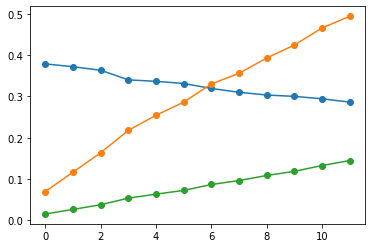

In [337]:
plt.plot(f.values[:,2], marker="o")
plt.plot(f.values[:,3], marker="o")
plt.plot(f.values[:,1]/len(X0), marker="o")

In [340]:
for n in range(1,8):
    print_rule(a.rules[f"Rule_{n}"])
    print("\n")

Operator:  and
+------+-----------------------------+------+-----------+
| Item | Variable                    | Sign |     Value |
+------+-----------------------------+------+-----------+
|  1   | avg_bal_min_4m              |  <=  |    583.60 |
|  2   | dr_txn_std_6m               |  >   |     26.67 |
|  3   | max_last_payment_date_ndays |  <=  | 19,187.50 |
|  4   | avg_bal_median_4m           |  <=  |    437.06 |
|  5   | dr_txn_std_12m              |  >   |     81.88 |
|  6   | atm_rcm_cdm_amt_lag12       |  <=  |  3,850.00 |
+------+-----------------------------+------+-----------+


Operator:  and
+------+--------------------------+------+--------+
| Item | Variable                 | Sign |  Value |
+------+--------------------------+------+--------+
|  1   | avg_bal_min_4m           |  <=  | 653.10 |
|  2   | dr_txn_std_6m            |  >   |  26.39 |
|  3   | atm_rcm_cdm_txn_std_6m   |  >   |   5.27 |
|  4   | k_plus_txn_lag06         |  >   |  21.50 |
|  5   | age_of_applican

In [ ]:
aX = X0.copy()
ay = y0.copy()
kwds = dict(n_estimators=10,
            max_depth=None,  
            min_samples_leaf=int(sum(ay)*0.01),
            max_features="sqrt", 
            random_state=0, 
            bootstrap=True)
Tree  = RandomForestClassifier(**kwds).fit(aX, ay)
paths = GetDecisionPaths(min_precision=0.4).fit(Tree, list(aX))

In [ ]:
tree_rules['T0-5']

In [ ]:
converted_X, tree_rules = RuleToFeature(aX, paths.decision_paths)

In [ ]:
asso1 = AssoRuleMining(metric="f1", operator="or", 
                       n_jobs=-1, n_batches=5).fit(converted_X, ay, rules=tree_rules)

In [ ]:
pd.DataFrame(asso1.info).sort_values(by=["f1_score","n_features"], ascending=[False,True]).head()

For this example, we focus on `f1-score`. Hence, we choose rule(s) that has the highest `f1-score` accordingly. In the case of a tie, we select `variable`, whose number of features is the lowest. This is for the sake of reducing rule complexity.

To create $1^{st}$ rule, we use **`RuleToFeature`** to convert rules into features array.

In [ ]:
rule1_index = "T5-456"
FirstRule = RuleToFeature(X0, asso1.asso_results_, which_rules=["T5-456"])

In [ ]:
FirstRule[0].values.sum()

In [ ]:
asso1.asso_results_

Use **`print_rule`** to tabulate rule information i.e. intervals.

In [ ]:
print_rule(FirstRule[1][rule1_index])

In [ ]:
flags = np.hstack(flags).sum(1)>0

In [ ]:
sum(flags.astype(int) - pp.astype(int))

In [ ]:
pp